# Modify aviation emissions
We use data from https://www.flightradar24.com/data/statistics to modify all NOx emissions. For the time period after this, the reduction factor reverts smoothly to 2/3rds the average for the last month we have data for, for the remainder of the 2 years, then returns to baseline. To represent this properly, additional years will be interpolated onto the data. 

Note that flightradar24 no longer reports the first few days of 2020 for free, so we update the data by adding rows rather than replacing the file. 

The consortium has so far agreed that only the NOx emissions from aircraft are important enough to model in this detail. If other emissions are desired, it would be necessary to change the variables `nox_input` and `key_variable` to the appropriate values for the new variable, after which the code could be run. 

In [1]:
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd


import os
import sys

sys.path.append(os.getcwd())
from utils import copy_netcdf_file, insert_interpolated_point, cutoff_netcdf_time, cleanup_files

# Running options
Here are the options for loading files and hopefully the only things that will need to be changed to run the code on different data. Assuming the data is updated monthly, the first two options will need updating every time. Other options will only need updating if you want to do a different calculation. 

In [2]:
# String appended on the end of all files. Update with every successful run where the data will be used
# (both with data change and with protocol change). 
version_str = "_v4.5.nc"  # CHANGE ON UPDATE

# which month's data should we use to base the "long tail" of the reversion to baseline? As a 2-digit string.
# Update if we have enough data to use a later month as the baseline. 
month_plat = "06"  # CHANGE ON UPDATE

# variables for loading files
input_folder = "../input/"
output_folder = "../output/aviation/"
# Name of the input netcdf file to read
nox_input = "CO2-em-AIR-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
# "NOx-em-AIR-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
# name of the variable in the file
key_variable = "CO2_em_AIR_anthro"
input_flights = "total-number-of-flights-3yrs.csv"

scenario_string = "_flightrd_mp{}".format(month_plat)

def convert_years_to_days(year):  # Data is recorded in 365-day years
    return (year - 2015) * 365

# We don't want data after 2050.
tcutoff = convert_years_to_days(2030.99)
tstart = None

# Years to interpolate, as number of years after 2015. 
yeardif_to_interpolate = [1, 2, 3, 4, 6, 7, 8, 9, 10]  
working_string = "_workings"

daily_for_2020 = False
if daily_for_2020:
    scenario_string = scenario_string + "_daily"
    tcutoff = convert_years_to_days(2030 + 1 / 12)
    tcutoff_final = convert_years_to_days(2020 + 7 / 12)
    tstart = convert_years_to_days(2020)

Only change lines below here if you know what you're doing. 
# Calculations begin

In [3]:
flights_change = pd.read_csv(input_folder + input_flights)
flights_change.tail(35)

,Date,2017,2018,2019,2020
331,27/11/2020,159996.0,172106.0,179689.0,NaN
332,28/11/2020,162968.0,173544.0,153284.0,NaN
333,29/11/2020,165255.0,175446.0,165165.0,NaN
334,30/11/2020,167725.0,173885.0,167407.0,NaN
335,01/12/2020,168869.0,141667.0,166264.0,NaN
336,02/12/2020,142774.0,144297.0,181253.0,NaN
337,03/12/2020,142939.0,165752.0,192123.0,NaN
338,04/12/2020,154611.0,175837.0,195532.0,NaN
339,05/12/2020,155260.0,177014.0,197228.0,NaN
340,06/12/2020,164144.0,175950.0,195281.0,NaN


In [4]:
# We will use a baseline of the weekly averaged 2019 data, normalised using Dec/Jan values for 2018/2019 compared to 2019/2020. 
norm_factor_19 = (flights_change["2020"][:30].append(flights_change["2019"][335:])).mean() / (
    flights_change["2019"][:30].append(flights_change["2018"][335:])
).mean()
norm_factor_18 = (flights_change["2020"][:30].append(flights_change["2019"][335:])).mean() / (
    flights_change["2018"][:30].append(flights_change["2017"][335:])
).mean()
norm_table = pd.Series(
    {
        ind: np.nanmean((flights_change["2019"][ind:ind+6] * norm_factor_19).append(
            flights_change["2018"][ind:ind+6] * norm_factor_18
        ) ) for ind in range(
            max(flights_change["2020"].dropna().index)
        )
    }
)

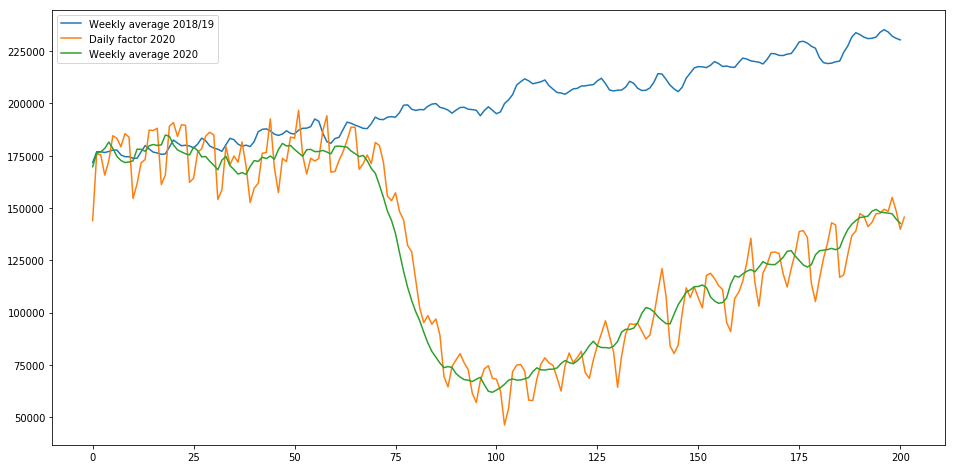

In [5]:
plt.figure(figsize=(16, 8))
plt.plot(norm_table)
plt.plot(flights_change["2020"])
plt.plot(pd.Series({ind: np.nanmean(flights_change["2020"][ind:ind+6]) for ind in range(
            max(flights_change["2020"].dropna().index))}))
plt.legend(["Weekly average 2018/19", "Daily factor 2020", "Weekly average 2020"])

# Complementing the flight data
We will use a linear trend to continue the flight data until we reach a level of 2/3rds the average of the last month. 

In [6]:
flights_factor = flights_change["2020"] / norm_table
flights_factor.tail(14)

352   NaN
353   NaN
354   NaN
355   NaN
356   NaN
357   NaN
358   NaN
359   NaN
360   NaN
361   NaN
362   NaN
363   NaN
364   NaN
365   NaN
dtype: float64

In [7]:
plat_inds = [date[3:5] == month_plat for date in flights_change["Date"]]
flightsplat = 1 - 2 / 3 * (1 - np.mean(flights_factor.loc[plat_inds]))
print(flightsplat)

0.6891617084451125


In [8]:
start_fit = 125
fit = np.polyfit(range(len(flights_factor.dropna()))[start_fit:], flights_factor.dropna()[start_fit:], 1)
xs = range(start_fit, 366)
fitted_trend = np.poly1d(fit)(xs)
print(flightsplat)

0.6891617084451125


In [9]:
flights_list = flights_factor.dropna().to_list() + [
    min(np.poly1d(fit)(x), flightsplat) for x in range(len(flights_factor.dropna()), 366)
]

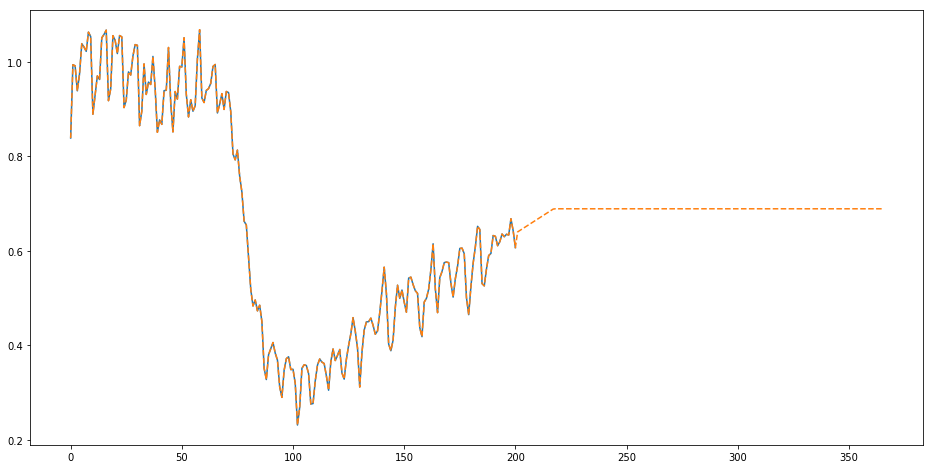

In [10]:
plt.figure(figsize=(16, 8))
plt.plot(flights_factor)
plt.plot(range(366), flights_list, linestyle="--")

In [11]:
flights = pd.DataFrame({"Flights": flights_list, "month": None})
flights

,Flights,month
0,0.838951,None
1,0.994173,None
2,0.991693,None
3,0.938754,None
4,0.974893,None
...,...,...
361,0.689162,None
362,0.689162,None
363,0.689162,None
364,0.689162,None


In [12]:
flights["date"] = [date(year = 2020, month = 1, day = 1) + timedelta(days=i) for i in flights.index]
flights["month"] = [i.month for i in flights["date"]]
flights["date"]

0      2020-01-01
1      2020-01-02
2      2020-01-03
3      2020-01-04
4      2020-01-05
          ...    
361    2020-12-27
362    2020-12-28
363    2020-12-29
364    2020-12-30
365    2020-12-31
Name: date, Length: 366, dtype: object

In [13]:
flights

,Flights,month,date
0,0.838951,1,2020-01-01
1,0.994173,1,2020-01-02
2,0.991693,1,2020-01-03
3,0.938754,1,2020-01-04
4,0.974893,1,2020-01-05
...,...,...,...
361,0.689162,12,2020-12-27
362,0.689162,12,2020-12-28
363,0.689162,12,2020-12-29
364,0.689162,12,2020-12-30


In [14]:
if daily_for_2020:
    def weekly_group(x):
        return x // 7
    flights["week"] = weekly_group(flights.index)
    weekly_flight_chng = flights.groupby("week").mean()
    weekly_flight_chng
else:
    monthly_flight_chng = flights.groupby("month").mean()
    monthly_flight_chng

## Add interpolated years
To ensure that 2020 is anomalous, we will interpolate the expected values from 2019, 2021, 2022 and 2023 before modifying 2020. 

In [15]:
# Since the data is extensive, we will cut it up first
start = datetime.now()
data = cutoff_netcdf_time(input_folder, output_folder, nox_input, tcutoff, scenario_string="", compress=False)
end = datetime.now()
print(end - start)

0:00:05.000504


In [16]:
start = datetime.now()
if not daily_for_2020:
    for yeardif in yeardif_to_interpolate:
        for i in range(1,13):
            insert_interpolated_point(data, yeardif * 365 + data.variables["time"][(i - 1)], 12, i)
        end = datetime.now()
        print(end - start)
        print("Inserted data for {}".format(yeardif))
else:
    days = 5 * 365 + np.arange(0, 366, 7)
    for day in days:
        if day not in data.variables["time"][:]:
            insert_interpolated_point(data, day, 1, 1)
            print("Inserted data for {}".format(day))
    end = datetime.now()
    print(end - start)
    

0:00:25.481993
Inserted data for 1
0:00:51.249993
Inserted data for 2
0:01:16.565993
Inserted data for 3
0:01:41.575493
Inserted data for 4
0:01:56.268993
Inserted data for 6
0:02:11.049994
Inserted data for 7
0:02:25.259049
Inserted data for 8
0:02:39.212993
Inserted data for 9
0:02:53.233993
Inserted data for 10


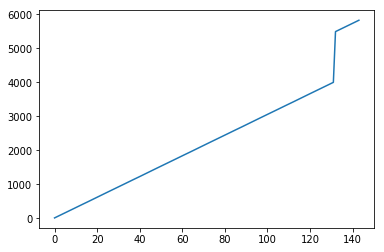

In [17]:
plt.plot(data.variables["time"])

# Perform the emissions modifications
We reduce the emissions in 2020 by a continuously changing amount, and the emissions in 2021 by a constant amount. First we copy and compress the interpolated data, then we modify it as a separate file. 

In [18]:
data.close()
if daily_for_2020:
    # We want to cut off slightly more data 
    data = cutoff_netcdf_time(
        output_folder, output_folder, 
        "cut_" + nox_input, tcutoff_final, "_baseline" + version_str, 
        tstart=tstart, compress=True, remove_string="cut_"
    )
else:
    data = copy_netcdf_file(
        "cut_" + nox_input, output_folder, output_folder, "_baseline" + version_str, compress=True
    )
data.close()

In [19]:
if daily_for_2020:
    data = cutoff_netcdf_time(
        output_folder, output_folder, 
        "cut_" + nox_input, tcutoff_final, working_string + version_str, 
        tstart=tstart, compress=True, remove_string="cut_"
    )
    output = data.variables[key_variable][:]
    for ind, time in enumerate(data.variables["time"][:]):
        output[:, ind, ...] *= weekly_flight_chng["Flights"].loc[(time - 365 * 5) // 7]
else:
    data = copy_netcdf_file(
        "cut_" + nox_input, output_folder, output_folder, working_string, compress=False
    )
    output = data.variables[key_variable][:]
    for time in range(1, 13):
        timeind = np.where(
            abs(data.variables["time"][:] - convert_years_to_days(2020 + (time - 0.5)/12)) == min(
                abs(data.variables["time"][:] - convert_years_to_days(2020 + (time - 0.5)/12))
            )
        )
        output[:, timeind, ...] *= monthly_flight_chng["Flights"].loc[time]
        # Then perform the factor-constant part for 2021
        timeind = np.where(
            abs(data.variables["time"][:] - convert_years_to_days(2021 + (time - 0.5)/12)) == min(
                abs(data.variables["time"][:] - convert_years_to_days(2021 + (time - 0.5)/12))
            )
        )    
        output[:, timeind, ...] *= monthly_flight_chng["Flights"].iloc[-1]

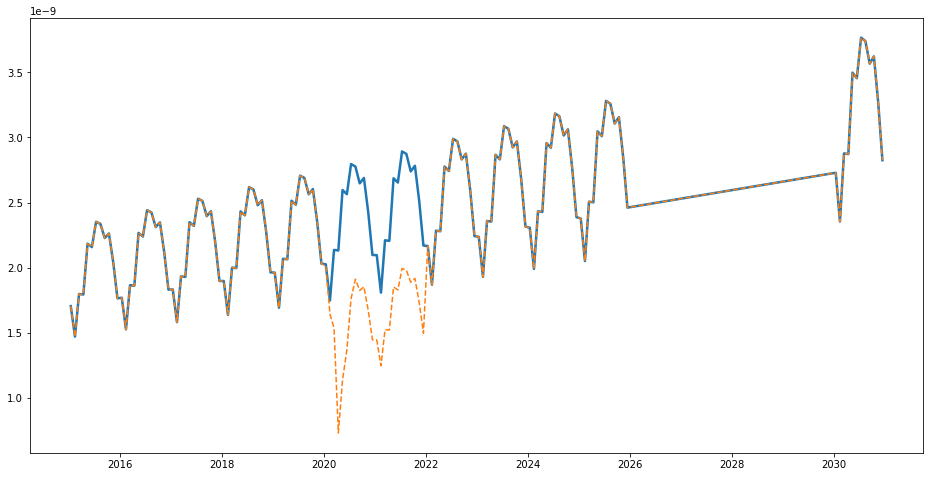

In [20]:
plt.figure(figsize=(16, 8))
plt.plot(data.variables["time"][:] / 365 + 2015, data.variables[key_variable][0, :, 283, 360], linewidth=2.5)
plt.plot(data.variables["time"][:] / 365 + 2015, output[0, :, 283, 360],  linestyle="--")

In [21]:
data.variables[key_variable][...] = output[...]
data.close()
# We also want to compress the data again
data = copy_netcdf_file(
    "cut_" + nox_input + working_string, output_folder, output_folder, 
    scenario_string + version_str, compress=True, remove_string=working_string
)

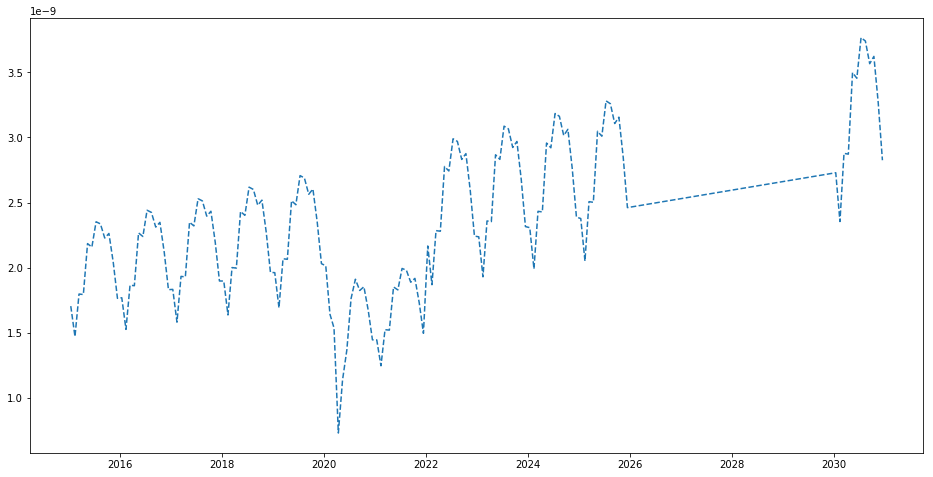

In [23]:
plt.figure(figsize=(16, 8))
plt.plot(data.variables["time"][:] / 365 + 2015, output[0, :, 283, 360],  linestyle="--")

In [24]:
data.close()

In [25]:
# This function will delete the files we don't want
cleanup_files(output_folder, working_string, scenario_string)

Deleting files ['cut_CO2-em-AIR-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc_workings', 'cut_NOx-em-AIR-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc_workings']


In [ ]:
# SANDBOX
stop

In [ ]:
output[timeind, ...]

In [ ]:
for h in range(1):
    plt.figure(figsize=(16, 8))
    plt.imshow(np.log((data.variables[key_variable][17, h, ::-1, :] - data.variables[key_variable][16, h, ::-1, :]) * 1e20 + 1))